In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.distributions import Normal
from scipy.stats import norm
import sdeint
from src.RC import *
%load_ext autoreload
%autoreload 2

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
    # random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
setup_seed(23)

**data**

$dX_t = \sigma(Y_t - X_t)dt + dB_t$ 

$dY_t = (X_t(\rho-Z_t)-Y_t)dt + dB_t$

$dZ_t = (X_tY_t-\beta Z_t)dt + dB_t$

where $\sigma = 10.$, $\rho = 28.$, $\beta = 8/3$


In [3]:
#generate data 
# load the data
trainLen = 2000
errorLen = 100
testLen = 2000
initLen = 100
minLen = min(trainLen-initLen, testLen)

# generate the ESN reservoir
inSize = outSize = 3
resSize = 1000

np.random.seed(42)

trajectory_N = 1000#number of trajectories
trajectory_len = trainLen + errorLen +testLen #length of each trajectory
trajectory_al = np.zeros((trajectory_N*inSize, trajectory_len))


delta_t = 0.00001
scale = 1000
dt= delta_t*scale #0.01

x0 = np.array([0.,1.,0.])

sigma = 10.
rho = 28.
beta = 8/3

t1 = np.arange(0, 41., delta_t)
t = np.arange(0, trajectory_len) * dt 

def f(x, t):
    dx = sigma*(x[1]-x[0])
    dy = x[0]*(rho-x[2])-x[1]
    dz = x[0]*x[1]-beta*x[2]
    return np.array([dx,dy,dz])

def g(x, t):
    return np.array([[3.,0.,0.]
                    ,[0.,3.,0.]
                    ,[0.,0.,3.]])

#The first run requires that the trajectory data be generated and saved

# for i in range(trajectory_N):
#     result = sdeint.itoEuler(f, g, x0, t1, generator = np.random.default_rng(i)) 
#     trajectory_al[i*inSize:(i+1)*inSize] = result.T[:,::scale]
# plt.plot(t, trajectory_al.T[:,:]) 

# t = t.reshape(-1,1)

In [4]:
trajectory_al.T.shape

(4100, 3000)

In [7]:
trajectory_all = np.load("./data/lorenztrack.npy")

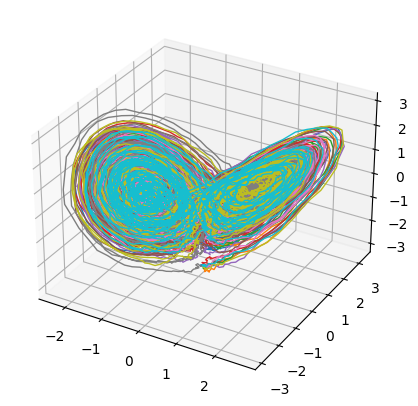

In [8]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')   #获取当前子图，指定三维模式
for i in range(0,30,3):
    ax.plot(trajectory_all.T[:,i],trajectory_all.T[:,i+1],trajectory_all.T[:,i+2],lw=1.0)


Text(0.5, 0, 'PDF')

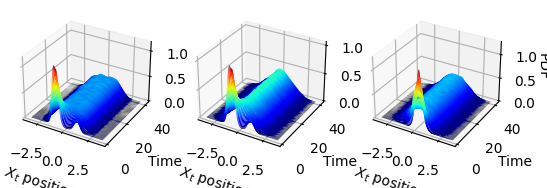

In [10]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp


datamin = np.min(trajectory_all)
datamax = np.max(trajectory_all)
x_axis = np.linspace(datamin, datamax, 200)
y_axis = np.arange(initLen,trajectory_len)*dt
X_axis, Y_axis = np.meshgrid(x_axis, y_axis)
data_Z1 = np.zeros((200, trajectory_len-initLen))
data_Z2 = np.zeros((200, trajectory_len-initLen))
data_Z3 = np.zeros((200, trajectory_len-initLen))
for i in range(0,trajectory_len-initLen):
    kde_data = sp.stats.gaussian_kde(trajectory_all[::inSize, initLen+i])
    data_Z1[:,i] = kde_data(x_axis).reshape(-1,)
    kde_data = sp.stats.gaussian_kde(trajectory_all[1::inSize, initLen+i])
    data_Z2[:,i] = kde_data(x_axis).reshape(-1,)
    kde_data = sp.stats.gaussian_kde(trajectory_all[2::inSize, initLen+i])
    data_Z3[:,i] = kde_data(x_axis).reshape(-1,)
    
fig = plt.figure()
ax = fig.add_subplot(131,projection = '3d')    
ax.plot_surface(X_axis, Y_axis, data_Z1.T, rstride=1,cstride=1,cmap=plt.cm.jet) 
ax.set_xlabel('$X_t$ position')
ax.set_ylabel('Time')
ax.set_zlabel('PDF', rotation =270, labelpad=-2.)
ax2 = fig.add_subplot(132,projection = '3d')    
ax2.plot_surface(X_axis, Y_axis, data_Z2.T, rstride=1,cstride=1,cmap=plt.cm.jet) 
ax2.set_xlabel('$X_t$ position')
ax2.set_ylabel('Time')
ax2.set_zlabel('PDF', rotation =270, labelpad=-2.)
ax3 = fig.add_subplot(133,projection = '3d')    
ax3.plot_surface(X_axis, Y_axis, data_Z3.T, rstride=1,cstride=1,cmap=plt.cm.jet) 
ax3.set_xlabel('$X_t$ position')
ax3.set_ylabel('Time')
ax3.set_zlabel('PDF', rotation =270, labelpad=-2.)

# fig.savefig('./image/OU3Dpdf.jpg',dpi=500,format='jpg')

**RC**

In [11]:
seed=42

**sinkhorn distance and error**

In [12]:
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).squeeze()

        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost, pi, C

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

**BO**

In [16]:
# #L2error
# import time
# T1 = time.perf_counter()

# # scikit optimize
# from skopt import gp_minimize
# from skopt.space import Real, Integer
# from skopt.utils import use_named_args

# space  = [Integer(1, 5, name='w_res_degree'),
#           Real(0.3, 1.5, "uniform", name='win_a'),
#           Real(0.05, 1., "uniform", name='alpha'),
#           Real(0.3, 1.5, "uniform", name='eig_rho'),
#           Real(1e-10, 1e+0, "log-uniform", name='reg')
#          ]
# default_parameters = [4, 1., 0.3, 1.25, 1e-8]

# @use_named_args(space)

# def optimization_l2(alpha, eig_rho, w_res_degree, win_a, reg):
#     print('*******************')
#     print('win_a: %.4f'%(win_a))
#     print('w_degree:', w_res_degree)
#     print('alpha rate: %.6f'%(alpha))
#     print('eig_rho: %.6f'%(eig_rho))
#     print('res: %.6f'%(reg))
    
#     Win = W_in(resSize, inSize, win_a, seed)
#     W = W_res(w_res_degree, resSize, eig_rho)

#     ESN_par = [resSize, alpha, reg, trainLen, initLen, inSize, trajectory_N]

#     Wout, last_res = create_ESN(ESN_par, trajectory_all, Win, W)
    
# #     errorLen = 1999
#     error_val,last_res_val = error_cal(trajectory_all, trajectory_N, last_res, outSize, inSize, trainLen, errorLen, Wout, W, Win, alpha)
#     return error_val

# op_gp_l2 = gp_minimize(optimization_l2, space, n_calls=50, random_state=10, x0 = default_parameters)

# T2 =time.perf_counter()
# print('Program run time:%s seconds' % ((T2 - T1)))

In [17]:

# print("""Best score=%.4f
# Best parameters:
# - degree=%d
# - win_rho=%.6f
# - leak rate=%.6f
# - w_res_eig_rho=%.6f
# - res_para=%.10f""" % (op_gp_l2.fun, op_gp_l2.x[0], op_gp_l2.x[1], 
#                             op_gp_l2.x[2], op_gp_l2.x[3], 
#                             op_gp_l2.x[4]))
# print(np.array([op_gp_l2.x[0], op_gp_l2.x[1], op_gp_l2.x[2], op_gp_l2.x[3], op_gp_l2.x[4]]))

# from skopt.plots import plot_convergence

# plot_convergence(op_gp_l2)

In [18]:
# from skopt.plots import plot_objective, plot_evaluations
# _ = plot_objective(op_gp_l2, n_points=40)
# plot_evaluations(op_gp_l2)

**!!!Remember to change the file name**

In [19]:
# hy = np.array([op_gp_l2.x[0], op_gp_l2.x[1], op_gp_l2.x[2], op_gp_l2.x[3], op_gp_l2.x[4]])
# np.save('./data/lorenz.npy',hy)

In [20]:

# #hyper
# w_degree = 4
# win_a = 1
# a = 0.3  # leaking rate
# eig_rho = 1.25
# reg = 1e-8  # regularization coefficient


# #hyper
# w_degree = op_gp_l2.x[0]
# win_a = op_gp_l2.x[1]
# a = op_gp_l2.x[2]  # leaking rate
# eig_rho = op_gp_l2.x[3]
# reg = op_gp_l2.x[4]  # regularization coefficient

hy = np.load('./data/lorenz.npy')
#hyper
w_degree = hy[0]
win_a = hy[1]
a = hy[2]  # leaking rate
eig_rho = hy[3]
reg = hy[4]  # regularization coefficient



Computing spectral radius...6.323710898800188 done.
Reservoir states shape: (1004, 1900000)
Train data flatten shape:(3, 1900000)
Last reservoir shape: (1000, 1000)
**Reservoir states collection finished**
MSE in training = 0.0012269862786197224
MSE = 0.0012316833328264957


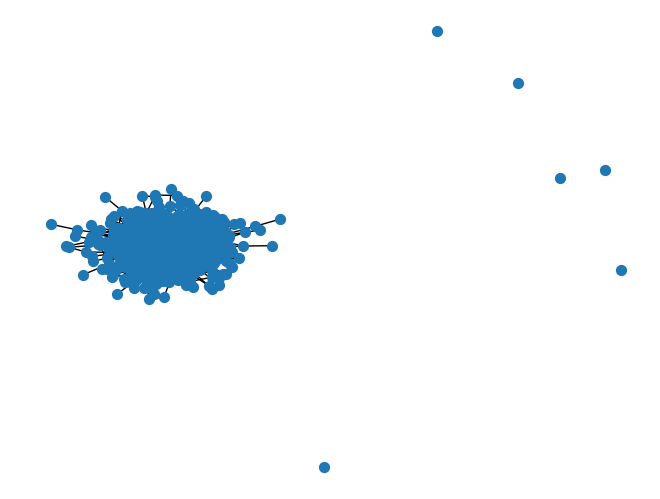

In [21]:
Win = W_in(resSize, inSize, win_a, seed)
W = W_res(w_degree, resSize,eig_rho)

ESN_par = [resSize, a, reg, trainLen, initLen, inSize, trajectory_N]

Wout, last_res = create_ESN(ESN_par, trajectory_all, Win, W)

error,last_res_for_test = error_cal(trajectory_all, trajectory_N, last_res, outSize, inSize, trainLen, errorLen, Wout, W, Win, a)

**RC prediction**

In [22]:
#RC prediction
y_pred = prediction(trajectory_all, trajectory_N, last_res_for_test, outSize, inSize, trainLen+errorLen, testLen, Wout, W, Win, a)


In [23]:
y_pred.shape

(3000, 2000)

In [27]:
#X,Y,Z,separate

y_pred1 = y_pred[0::3,:]
y_pred2 = y_pred[1::3,:]
y_pred3 = y_pred[2::3,:]

**error modelling**

(generate error samples)

In [35]:
#non-rolling error boxplot
y_train_nr = errortrain_NR(ESN_par, trajectory_all, Win, W, Wout)
print(y_train_nr.shape)
# y_train_nr_reshape = y_train_nr.reshape(trajectory_N, -1)

error_train_nr = y_train_nr - trajectory_all[:, initLen +1: trainLen +1]
error_train_nr.shape

Reservoir states shape: (1004, 1900000)

**Reservoir states collection finished**
(3000, 1900)


(3000, 1900)

**NF**

In [40]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser


from src.flows import *
from src.models import NormalizingFlowModel, TemporalNormalizingFlowModel


def plot_data(x, bandwidth = 0.2, **kwargs):
    kde = sp.stats.gaussian_kde(x[:,0])
    x_axis = np.linspace(-1, 1, 200)
    plt.plot(x_axis, kde(x_axis), **kwargs)
#     plt.axis("off")
# torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())
# torch.cuda.set_device(0)

In [41]:
#convert to matric (inSize,time*trajectory_N)
error_train_nr_flatten = np.zeros((inSize,error_train_nr.shape[1]*trajectory_N))
for n in range(trajectory_N):
    error_train_nr_flatten[:,n*error_train_nr.shape[1]:(n+1)*error_train_nr.shape[1]] = error_train_nr[n*inSize:(n+1)*inSize,:]
    

    

In [42]:
import time
#non-rolling nf

T3 =time.perf_counter()
try: 
    torch.set_default_tensor_type('torch.FloatTensor')
except:
    pass

argparser = ArgumentParser()
argparser.add_argument("--n", default=512, type=int)
argparser.add_argument("--flows", default=2, type=int)
argparser.add_argument("--flow", default="NSF_AR", type=str)
argparser.add_argument("--iterations", default=500, type=int)
args = argparser.parse_args(args=[])

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

flow = eval(args.flow)
flows = [flow(dim=3) for _ in range(args.flows)]
model_nr = NormalizingFlowModel(dim=3, flows=flows)

optimizer = optim.Adam(model_nr.parameters(), lr=0.005)
x_ = torch.Tensor(error_train_nr_flatten.T)
x = torch.zeros_like(x_)

for i in range(x_.shape[1]):
    x[:,i] = (x_[:,i] - torch.mean(x_[:,i])) / torch.std(x_[:,i])

for i in range(args.iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det = model_nr(x)
    logprob = prior_logprob + log_det
    loss = -torch.mean(prior_logprob + log_det)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Iter: {i}\t" +
                    f"Logprob: {logprob.mean().data:.2f}\t" +
                    f"Prior: {prior_logprob.mean().data:.2f}\t" +
                    f"LogDet: {log_det.mean().data:.2f}")

T4 =time.perf_counter()
print('Program run time:%s seconds' % ((T4 - T3)))

Iter: 0	Logprob: -5.69	Prior: -5.23	LogDet: -0.46
Iter: 100	Logprob: -4.26	Prior: -4.27	LogDet: 0.01
Iter: 200	Logprob: -4.26	Prior: -4.26	LogDet: 0.00
Iter: 300	Logprob: -4.26	Prior: -4.26	LogDet: 0.00
Iter: 400	Logprob: -4.26	Prior: -4.26	LogDet: 0.00
程序运行时间:1096.684821004048秒


standardization $x = (x_{init} - x_{mean})/x_{std}$

<!-- k=5,b=3
#error time interval 100
![image.png](attachment:image.png)
#error time interval 100-199
![image-2.png](attachment:image-2.png)
#error time interval 100-1099
![image-3.png](attachment:image-3.png)
#error time interval 100-1999
![image-4.png](attachment:image-4.png) -->

In [44]:
error_samples_nr_ = model_nr.sample(trajectory_N * testLen).data.numpy()
error_samples_nr = error_samples_nr_ * torch.std(x_[:,0]).numpy() + torch.mean(x_[:,0]).numpy()

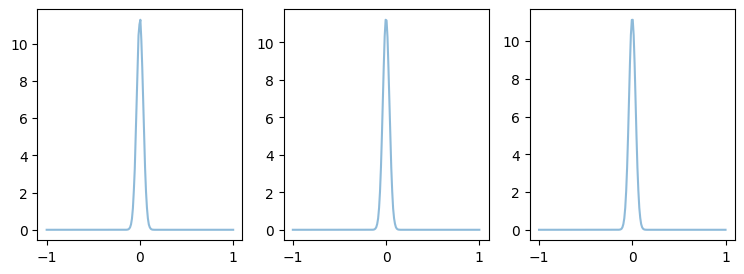

In [45]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plot_data(error_samples_nr[:,0].reshape(-1,1), alpha=0.5)
plt.subplot(1, 3, 2)
plot_data(error_samples_nr[:,1].reshape(-1,1), alpha=0.5)
plt.subplot(1, 3, 3)
plot_data(error_samples_nr[:,2].reshape(-1,1), alpha=0.5)


**RC-NF rolling predicitions**

In [46]:
#non-rolling nf prediction
y_pred_error_nr = predictionError_NR(trajectory_all, trajectory_N, last_res_for_test, outSize, inSize, trainLen+errorLen, testLen, Wout, W, Win, a, error_samples_nr)



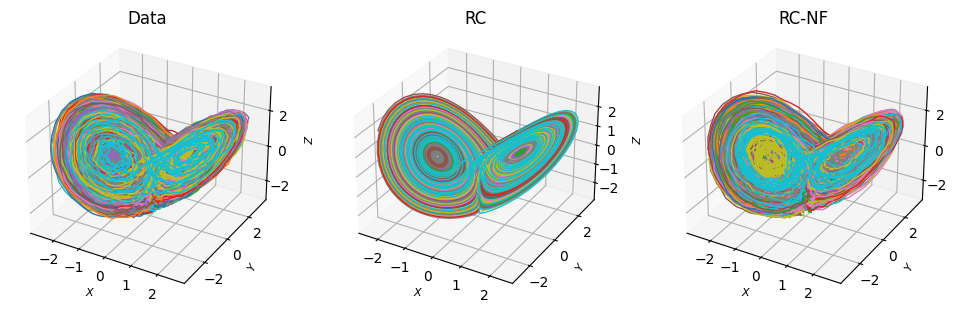

In [116]:
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(wspace=0.2)
ax = fig.add_subplot(131,projection = '3d')  
for i in range(0,trajectory_all.shape[0],3):
    ax.plot(trajectory_all.T[trainLen+errorLen+1:,i],trajectory_all.T[trainLen+errorLen+1:,i+1],trajectory_all.T[trainLen+errorLen+1:,i+2],lw=1.0)
ax.set_xlabel('$X$', fontsize=8, labelpad=-4)
ax.set_ylabel('$Y$', rotation =60, fontsize=8, labelpad=-4)
ax.set_zlabel('$Z$', rotation =270, fontsize=8, labelpad=-4) 
ax.tick_params(pad=-2)
ax.set_title('Data',pad=-4)

ax2 = fig.add_subplot(132,projection = '3d')  
for i in range(0,trajectory_N):
    ax2.plot(y_pred1.T[:,i],y_pred2.T[:,i],y_pred3.T[:,i],lw=1.0)
ax2.set_xlabel('$X$', fontsize=8, labelpad=-4)
ax2.set_ylabel('$Y$',  rotation =60, fontsize=8, labelpad=-4)
ax2.set_zlabel('$Z$', rotation =270, labelpad=-4, fontsize=8)   
ax2.tick_params(pad=-2)    
ax2.set_title('RC',pad=-4)

ax3 = fig.add_subplot(133,projection = '3d')  
for i in range(0,y_pred_error_nr.shape[0],3):
    ax3.plot(y_pred_error_nr.T[:,i],y_pred_error_nr.T[:,i+1],y_pred_error_nr.T[:,i+2],lw=1.0)
ax3.set_xlabel('$X$', fontsize=8, labelpad=-4)
ax3.set_ylabel('$Y$', rotation =60, fontsize=8, labelpad=-4)
ax3.set_zlabel('$Z$', rotation =270, labelpad=-4, fontsize=8)   
ax3.tick_params(pad=-2)
ax3.set_title('RC-NF',pad=-4)
    
# fig.savefig('./image/lorenz/attractor.jpg',dpi=500,format='jpg')

In [50]:
#X,Y,Z,seperate

y_pred_error_nr1 = y_pred_error_nr[0::3,:]
y_pred_error_nr2 = y_pred_error_nr[1::3,:]
y_pred_error_nr3 = y_pred_error_nr[2::3,:]

In [112]:
datamin = np.min((trajectory_all[:,trainLen+errorLen+1:trainLen+errorLen+1+minLen], y_pred[:,:minLen], y_pred_error_nr[:,:minLen]))
datamax = np.max((trajectory_all[:,trainLen+errorLen+1:trainLen+errorLen+1+minLen], y_pred[:,:minLen], y_pred_error_nr[:,:minLen]))
x_axis = np.linspace(datamin, datamax, 200)
y_axis = np.arange(trainLen+errorLen+1, trainLen+errorLen+1+minLen)*dt
X_axis, Y_axis = np.meshgrid(x_axis, y_axis)

data_Z1 = np.zeros((200, minLen))
data_Z2 = np.zeros((200, minLen))
data_Z3 = np.zeros((200, minLen))
data_Z4 = np.zeros((200, minLen))
data_Z5 = np.zeros((200, minLen))
data_Z6 = np.zeros((200, minLen))
data_Z7 = np.zeros((200, minLen))
data_Z8 = np.zeros((200, minLen))
data_Z9 = np.zeros((200, minLen))

for i in range(0,minLen):
    kde_data = sp.stats.gaussian_kde(y_pred_error_nr1[:, i])
    data_Z7[:,i] = kde_data(x_axis).reshape(-1,)
    kde_data = sp.stats.gaussian_kde(y_pred_error_nr2[:, i])
    data_Z8[:,i] = kde_data(x_axis).reshape(-1,)
    kde_data = sp.stats.gaussian_kde(y_pred_error_nr3[:, i])
    data_Z9[:,i] = kde_data(x_axis).reshape(-1,)
    
    kde_data = sp.stats.gaussian_kde(trajectory_all[0::inSize, trainLen+errorLen+1+i])
    data_Z1[:,i] = kde_data(x_axis).reshape(-1,)
    kde_data = sp.stats.gaussian_kde(trajectory_all[1::inSize, trainLen+errorLen+1+i])
    data_Z2[:,i] = kde_data(x_axis).reshape(-1,)
    kde_data = sp.stats.gaussian_kde(trajectory_all[2::inSize, trainLen+errorLen+1+i])
    data_Z3[:,i] = kde_data(x_axis).reshape(-1,)
    
    kde_data = sp.stats.gaussian_kde(y_pred1[:, i])
    data_Z4[:,i] = kde_data(x_axis).reshape(-1,)
    kde_data = sp.stats.gaussian_kde(y_pred2[:, i])
    data_Z5[:,i] = kde_data(x_axis).reshape(-1,)
    kde_data = sp.stats.gaussian_kde(y_pred3[:, i])
    data_Z6[:,i] = kde_data(x_axis).reshape(-1,)
    


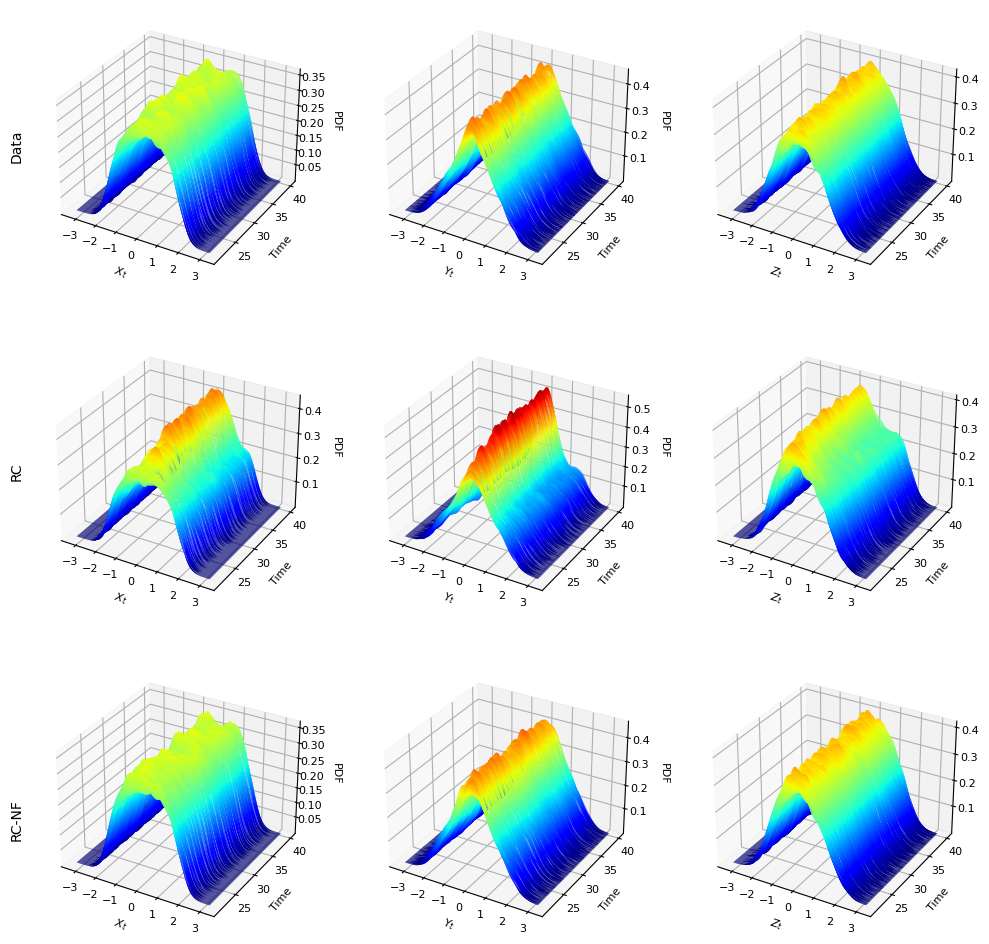

In [140]:
zmax = np.max((data_Z1, data_Z2, data_Z3,data_Z4,data_Z5,data_Z6,data_Z7,data_Z8,data_Z9))
norm = mpl.colors.Normalize(vmin=0,vmax=zmax+0.01)

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(wspace=0.2)
ax = fig.add_subplot(331,projection = '3d')    
ax.plot_surface(X_axis, Y_axis, data_Z1.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax.set_xlabel('$X_t$', fontsize=8, labelpad=-4)
ax.set_ylabel('Time', rotation =50, fontsize=8, labelpad=-4)
ax.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax.tick_params(pad=-2, labelsize=8)
ax2 = fig.add_subplot(332,projection = '3d')    
ax2.plot_surface(X_axis, Y_axis, data_Z2.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax2.set_xlabel('$Y_t$', fontsize=8, labelpad=-4)
ax2.set_ylabel('Time', rotation =50, fontsize=8, labelpad=-4)
ax2.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax2.tick_params(pad=-2, labelsize=8)
ax3 = fig.add_subplot(333,projection = '3d')    
ax3.plot_surface(X_axis, Y_axis, data_Z3.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax3.set_xlabel('$Z_t$', fontsize=8, labelpad=-4)
ax3.set_ylabel('Time', rotation =50, fontsize=8, labelpad=-4)
ax3.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax3.tick_params(pad=-2, labelsize=8)

ax4 = fig.add_subplot(334,projection = '3d')    
ax4.plot_surface(X_axis, Y_axis, data_Z4.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax4.set_xlabel('$X_t$ ', fontsize=8, labelpad=-4)
ax4.set_ylabel('Time', rotation =50, fontsize=8, labelpad=-4)
ax4.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax4.tick_params(pad=-2, labelsize=8)
ax5 = fig.add_subplot(335,projection = '3d')    
ax5.plot_surface(X_axis, Y_axis, data_Z5.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax5.set_xlabel('$Y_t$', fontsize=8, labelpad=-4)
ax5.set_ylabel('Time', rotation =50, fontsize=8, labelpad=-4)
ax5.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax5.tick_params(pad=-2, labelsize=8)
ax6 = fig.add_subplot(336,projection = '3d')    
ax6.plot_surface(X_axis, Y_axis, data_Z6.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax6.set_xlabel('$Z_t$' , fontsize=8, labelpad=-4)
ax6.set_ylabel('Time', rotation =50, fontsize=8, labelpad=-4)
ax6.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax6.tick_params(pad=-2, labelsize=8)

ax7 = fig.add_subplot(337,projection = '3d')    
ax7.plot_surface(X_axis, Y_axis, data_Z7.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax7.set_xlabel('$X_t$ ', fontsize=8, labelpad=-4)
ax7.set_ylabel('Time', rotation =50, fontsize=8, labelpad=-4)
ax7.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax7.tick_params(pad=-2, labelsize=8)
ax8 = fig.add_subplot(338,projection = '3d')    
ax8.plot_surface(X_axis, Y_axis, data_Z8.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax8.set_xlabel('$Y_t$', fontsize=8, labelpad=-4)
ax8.set_ylabel('Time',  rotation =50, fontsize=8, labelpad=-4)
ax8.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax8.tick_params(pad=-2, labelsize=8)
ax9 = fig.add_subplot(339,projection = '3d')    
ax9.plot_surface(X_axis, Y_axis, data_Z9.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm = norm) 
ax9.set_xlabel('$Z_t$', fontsize=8, labelpad=-4)
ax9.set_ylabel('Time',  rotation =50,fontsize=8, labelpad=-4)
ax9.set_zlabel('PDF', rotation =270, fontsize=8, labelpad=-4)
ax9.tick_params(pad=-2, labelsize=8)
fig.text(0.1,0.755, 'Data', rotation = 90)
fig.text(0.1,0.49, 'RC', rotation = 90)
fig.text(0.1,0.19, 'RC-NF', rotation = 90)
# fig.savefig('./image/lorenz/prediction3D.jpg', dpi=500,format='jpg')

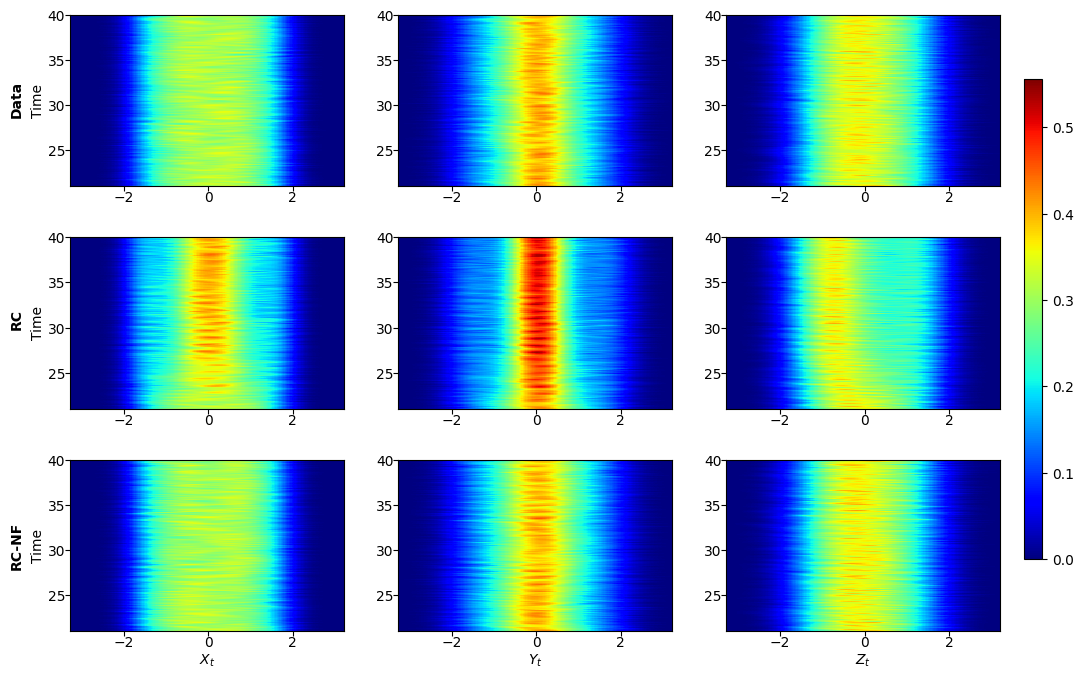

In [136]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3)
ax = fig.add_subplot(331)    
ax.pcolormesh(X_axis, Y_axis, data_Z1.T,cmap=plt.cm.jet,norm = norm) 
# ax.set_xlabel('$X_t$ position', labelpad=-3)
ax.set_ylabel('Time', labelpad=2)
ax.tick_params(pad=0)
# ax.set_zlabel('PDF', rotation =270, labelpad=-2.)
ax2 = fig.add_subplot(332)    
ax2.pcolormesh(X_axis, Y_axis, data_Z2.T,cmap=plt.cm.jet,norm = norm) 
# ax2.set_xlabel('$Y_t$ position', labelpad=-3)
# ax2.set_ylabel('Time', labelpad=-3)
ax2.tick_params(pad=0)
# ax2.set_zlabel('PDF', rotation =270, labelpad=-2.)
ax3 = fig.add_subplot(333)    
ax3.pcolormesh(X_axis, Y_axis, data_Z3.T,cmap=plt.cm.jet,norm = norm) 
# ax3.set_xlabel('$Z_t$ position', labelpad=-3)
# ax3.set_ylabel('Time', labelpad=-3)
ax3.tick_params(pad=0)
# ax3.set_zlabel('PDF', rotation =270, labelpad=-2.)

ax4 = fig.add_subplot(334)    
ax4.pcolormesh(X_axis, Y_axis, data_Z4.T,cmap=plt.cm.jet,norm = norm) 
# ax4.set_xlabel('$X_t$ position', labelpad=-3)
ax4.set_ylabel('Time', labelpad=2)
ax4.tick_params(pad=0)
# ax4.set_zlabel('PDF', rotation =270, labelpad=-2.)
ax5 = fig.add_subplot(335)    
ax5.pcolormesh(X_axis, Y_axis, data_Z5.T,cmap=plt.cm.jet,norm = norm) 
# ax5.set_xlabel('$Y_t$ position', labelpad=-3)
# ax5.set_ylabel('Time', labelpad=-3)
ax5.tick_params(pad=0)
# ax5.set_zlabel('PDF', rotation =270, labelpad=-2.)
ax6 = fig.add_subplot(336)    
ax6.pcolormesh(X_axis, Y_axis, data_Z6.T,cmap=plt.cm.jet,norm = norm) 
# ax6.set_xlabel('$Z_t$ position', labelpad=-3)
# ax6.set_ylabel('Time', labelpad=-3)
ax6.tick_params(pad=0)

ax7 = fig.add_subplot(337)    
ax7.pcolormesh(X_axis, Y_axis, data_Z7.T,cmap=plt.cm.jet,norm = norm) 
ax7.set_xlabel('$X_t$', labelpad=2)
ax7.set_ylabel('Time', labelpad=2)
ax7.tick_params(pad=0)
# ax4.set_zlabel('PDF', rotation =270, labelpad=-2.)
ax8 = fig.add_subplot(338)    
ax8.pcolormesh(X_axis, Y_axis, data_Z8.T,cmap=plt.cm.jet,norm = norm) 
ax8.set_xlabel('$Y_t$', labelpad=2)
# ax8.set_ylabel('Time', labelpad=-3)
ax8.tick_params(pad=0)
# ax5.set_zlabel('PDF', rotation =270, labelpad=-2.)
ax9 = fig.add_subplot(339)    
im=ax9.pcolormesh(X_axis, Y_axis, data_Z9.T,cmap=plt.cm.jet,norm = norm) 
ax9.set_xlabel('$Z_t$', labelpad=2)
# ax9.set_ylabel('Time', labelpad=-3)
ax9.tick_params(pad=0)
position = fig.add_axes([0.92, 0.2, 0.015,0.6])
fig.colorbar(im, cax= position)
fig.text(0.075,0.755, 'Data', rotation = 90,weight='heavy')
fig.text(0.075,0.49, 'RC', rotation = 90,weight='heavy')
fig.text(0.075,0.19, 'RC-NF', rotation = 90,weight='heavy')
# ax6.set_zlabel('PDF', rotation =270, labelpad=-2.)
# fig.savefig('./image/lorenz/predictionhot.jpg', dpi=500,format='jpg')

In [56]:
error_train_nr.shape

(3000, 1900)

In [57]:
#flatten insize* (minlen*trajectory_N)
trajectory_flatten = np.zeros((inSize, minLen*trajectory_N))
y_pred_flatten = np.zeros((inSize, minLen*trajectory_N))
y_pred_nr_flatten = np.zeros((inSize, minLen*trajectory_N))

for j in range(trajectory_N):
    trajectory_flatten[:, j*minLen:(j+1)*minLen] = trajectory_all[j*inSize:(j+1)*inSize, trainLen + errorLen + 1:trainLen + errorLen + 1 + minLen]
    y_pred_flatten[:, j*minLen:(j+1)*minLen] = y_pred[j*inSize:(j+1)*inSize, :minLen]
    y_pred_nr_flatten[:, j*minLen:(j+1)*minLen] = y_pred_error_nr[j*inSize:(j+1)*inSize, :minLen]

In [61]:
trajectory_flatten.shape[1]

1900000

**Wasserstein distance**

In [68]:
### calculate wasserstain distance, KL divergence 
try: 
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
except:
    pass


was_step = 1900*15
x_was_list_rc = [y_pred_flatten[:,i:i+was_step] for i in range(0,y_pred_flatten.shape[1],was_step)]
y_was_list_rc = [trajectory_flatten[:,i:i+was_step] for i in range(0,trajectory_flatten.shape[1],was_step)]

dist_was_rc = torch.empty(0)
for j in range(len(y_was_list_rc)):
    x_was_j_rc = torch.tensor(np.array(x_was_list_rc[j]).T, dtype=torch.float)
    y_was_j_rc = torch.tensor(np.array(y_was_list_rc[j]).T, dtype=torch.float)
    sinkhorn = SinkhornDistance(eps=0.01, max_iter=100, reduction=None)
    dist_was_j_rc, P, C = sinkhorn(x_was_j_rc, y_was_j_rc)
#     print(x_was_j_rc.shape, y_was_j_rc.shape, dist_was_j_rc)
    dist_was_rc = torch.cat((dist_was_rc, torch.tensor([dist_was_j_rc])))
    torch.cuda.empty_cache()
    
x_was_list_rcnr = [y_pred_nr_flatten[:,i:i+was_step] for i in range(0,y_pred_nr_flatten.shape[1],was_step)]
y_was_list_rcnr = [trajectory_flatten[:,i:i+was_step] for i in range(0,trajectory_flatten.shape[1],was_step)]

dist_was_rcnr = torch.empty(0)

for j in range(len(y_was_list_rcnr)):
    x_was_j_rcnr = torch.tensor(np.array(x_was_list_rcnr[j]).T, dtype=torch.float)
    y_was_j_rcnr = torch.tensor(np.array(y_was_list_rcnr[j]).T, dtype=torch.float)
    sinkhorn = SinkhornDistance(eps=0.01, max_iter=100, reduction=None)
    dist_was_j_rcnr, P, C = sinkhorn(x_was_j_rcnr, y_was_j_rcnr)
#     print(x_was_j_rcnr.shape, y_was_j_rcnr.shape, dist_was_j_rcnr)
    dist_was_rcnr = torch.cat((dist_was_rcnr, torch.tensor([dist_was_j_rcnr])))
    torch.cuda.empty_cache()

# dist_was_rc, P, C = sinkhorn(x_was_rc, y_was_rc)
print(dist_was_rc.shape, "Sinkhorn distance (RC):", dist_was_rc.cpu().numpy(), "Sinkhorn distance (RC mean):", dist_was_rc.cpu().numpy().mean())
print(dist_was_rcnr.shape,"Sinkhorn distance (RCNR):", dist_was_rcnr.cpu().numpy(),"Sinkhorn distance (RCNR mean):", dist_was_rcnr.cpu().numpy().mean())

torch.Size([67]) Sinkhorn distance (RC): [0.02806098 0.0373029  0.06504408 0.0386744  0.07925774 0.06027989
 0.03003194 0.0988616  0.04169682 0.02834207 0.0472535  0.04649858
 0.08982935 0.02737233 0.04862297 0.04150732 0.03804154 0.03851256
 0.03963674 0.04654776 0.06095399 0.06582448 0.03606812 0.05947749
 0.06518526 0.03551149 0.06112741 0.02705129 0.04701311 0.02867414
 0.08424917 0.04328489 0.02870577 0.0455533  0.07391682 0.03360891
 0.06754653 0.03414148 0.02245077 0.0472978  0.04805055 0.04610126
 0.03442271 0.0653911  0.06194646 0.04233277 0.0627195  0.07339234
 0.03765349 0.04607179 0.03954061 0.03843882 0.06420226 0.0442138
 0.04346951 0.02413322 0.02960371 0.07018687 0.029674   0.03070913
 0.05030765 0.03059604 0.0601792  0.05355965 0.04164267 0.05863152
 0.04434565] Sinkhorn distance (RC mean): 0.04791841
torch.Size([67]) Sinkhorn distance (RCNR): [0.02862122 0.01814151 0.02159923 0.01921517 0.02304488 0.01989033
 0.02506617 0.01859291 0.02523526 0.04330549 0.02591535 0.02

**KL divergence**

In [69]:
try: 
    torch.set_default_tensor_type('torch.FloatTensor')
except:
    pass

In [70]:
def KL(y_t, y_p, bins, low, high):
    y_t = y_t.reshape(-1, )
    y_p = y_p.reshape(-1, )
    yt_hist, bins = np.histogram(y_t, bins = bins,range = (low,high),density = True)
    yp_hist, bins = np.histogram(y_p, bins = bins,range = (low,high),density = True)
#     print(yt_hist,yp_hist)
    D = scipy.stats.entropy(yt_hist, yp_hist)
    
    return D
    
def torch_KL(y_t, y_p, bins):
    y_t = torch.tensor(y_t.reshape(-1, ))
    y_p = torch.tensor(y_p.reshape(-1, ))
    low = float(torch.min(y_t.min(), y_p.min()).cpu().numpy())
    high = float(torch.max(y_t.max(), y_p.max()).cpu().numpy())

    yt_hist, tbins = torch.histogram(y_t, bins = bins,range = (low,high),density = True)
    yp_hist, pbins = torch.histogram(y_p, bins = bins,range = (low,high),density = True)
    
    yt_hist_log = torch.log(yt_hist + 1e-8)
    kl_loss = nn.KLDivLoss() 
#     print(yt_hist,yp_hist)
    D = kl_loss(yt_hist_log, yp_hist)
    
    return D

def torch_KL_3(y_t, y_p, bins):
    y_t = np.array([y_t[0::inSize].reshape(-1,), y_t[1::inSize].reshape(-1,), y_t[2::inSize].reshape(-1,)]).T
    y_p = np.array([y_p[0::inSize].reshape(-1,), y_p[1::inSize].reshape(-1,), y_p[2::inSize].reshape(-1,)]).T

    low = float(np.min([y_t.min(), y_p.min()]))
    high = float(np.max([y_t.max(), y_p.max()]))

    yt_hist, tbins = np.histogramdd(y_t, bins = (bins,bins,bins),range = [[low,high],[low,high],[low,high]],density = True)
    yp_hist, pbins = np.histogramdd(y_p, bins = (bins,bins,bins),range = [[low,high],[low,high],[low,high]],density = True)
    
    yt_hist = torch.tensor(yt_hist)
    yp_hist = torch.tensor(yp_hist)
    
    yt_hist_log = torch.log(yt_hist + 1e-8)
    kl_loss = nn.KLDivLoss() 
#     print(yt_hist,yp_hist)
    D = kl_loss(yt_hist_log, yp_hist)
    
    return D

In [71]:

    

KL_all_rc = torch_KL_3(y_t = trajectory_flatten, y_p = y_pred_flatten, bins = 20)
KL_all_nr = torch_KL_3(y_t = trajectory_flatten, y_p = y_pred_nr_flatten, bins = 20)

/home/user/anaconda3/envs/fc/lib/python3.8/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [72]:
print("KL divergence (RC):", KL_all_rc.numpy())
print("KL divergence (RC-NF):", KL_all_nr.numpy())


KL divergence (RC): 0.00046666048786637835
KL divergence (RC-NF): 7.51462578672868e-06


In [73]:
trajectory_flatten.shape

(3, 1900000)

**criterion: close returns map**

In [76]:
#close returns
from scipy.spatial.distance import pdist
p = np.arange(1,901)
i = np.arange(0,1000)
trajectory_close_return = np.zeros((len(p), len(i)*trajectory_N))
y_pred_close_return = np.zeros((len(p), len(i)*trajectory_N))
y_pred_error_nr_close_return = np.zeros((len(p), len(i)*trajectory_N))

for j in range(trajectory_N):
    trajectory_close_return_j = np.zeros((len(p), len(i)))
    y_pred_close_return_j = np.zeros((len(p), len(i)))
    y_pred_error_nr_close_return_j = np.zeros((len(p), len(i)))
    for k in p:
        trajectory_close_return_j[k-1] = np.linalg.norm((trajectory_all[j*inSize:(j+1)*inSize, trainLen + errorLen + 1+i] - trajectory_all[j*inSize:(j+1)*inSize, trainLen + errorLen + 1+ k+i]), axis=0)
        y_pred_close_return_j[k-1] = np.linalg.norm((y_pred[j*inSize:(j+1)*inSize, i] - y_pred[j*inSize:(j+1)*inSize, k+i]), axis=0)
        y_pred_error_nr_close_return_j[k-1] = np.linalg.norm((y_pred_error_nr[j*inSize:(j+1)*inSize, i] - y_pred_error_nr[j*inSize:(j+1)*inSize, k+i]), axis=0)


    t_range =  np.max(pdist(trajectory_all[j*inSize:(j+1)*inSize, trainLen + errorLen + 1: trainLen + errorLen + 1 + minLen].T, 'euclidean'))
    yp_range =  np.max(pdist(y_pred[j*inSize:(j+1)*inSize, : minLen].T, 'euclidean')) 
    ypnr_range =  np.max(pdist(y_pred_error_nr[j*inSize:(j+1)*inSize, : minLen].T, 'euclidean'))

    trajectory_close_return[:, j*len(i):(j+1)*len(i)] = (trajectory_close_return_j<=0.08*t_range).astype(int)
    y_pred_close_return[:, j*len(i):(j+1)*len(i)] = (y_pred_close_return_j<=0.08*yp_range).astype(int)
    y_pred_error_nr_close_return[:, j*len(i):(j+1)*len(i)] = (y_pred_error_nr_close_return_j<=0.08*ypnr_range).astype(int)

# trajectory_close_return = trajectory_close_return[np.where(t_range 
# y_pred_close_return = y_pred_close_return / yp_range
# y_pred_error_nr_close_return = y_pred_error_nr_close_return/ ypnr_range
  


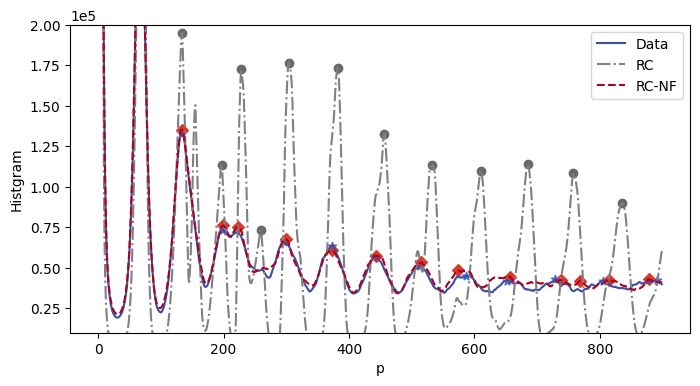

In [142]:
from scipy.signal import argrelextrema
plt.figure(figsize=(8,4))
plt.plot(np.sum(trajectory_close_return, axis=1), color = '#3951A2', label = 'Data')
peak1 = argrelextrema(np.sum(trajectory_close_return, axis=1), np.greater, order=20)[0]
plt.scatter(peak1, np.sum(trajectory_close_return, axis=1)[peak1], color = 'royalblue', marker='*')
plt.plot(np.sum(y_pred_close_return, axis=1), color = 'gray', linestyle='-.', label = 'RC')
peak2 = argrelextrema(np.sum(y_pred_close_return, axis=1), np.greater, order=20)[0]
plt.scatter(peak2, np.sum(y_pred_close_return, axis=1)[peak2], color = 'dimgray', marker = "o")
plt.plot(np.sum(y_pred_error_nr_close_return, axis=1),color= '#A80326', linestyle = '--', label = 'RC-NF')
peak3 = argrelextrema(np.sum(y_pred_error_nr_close_return, axis=1), np.greater, order=20)[0]
plt.scatter(peak3, np.sum(y_pred_error_nr_close_return, axis=1)[peak3], color = '#DA382A', marker = 'D')
plt.legend()
plt.ylim((10000,200000))
plt.ticklabel_format(axis='y', style= 'sci',scilimits=(0,0))
plt.ylabel('Histgram')
plt.xlabel('p')
# plt.savefig('./image/lorenz/closehistgram.jpg',dpi=500,format = 'jpg')

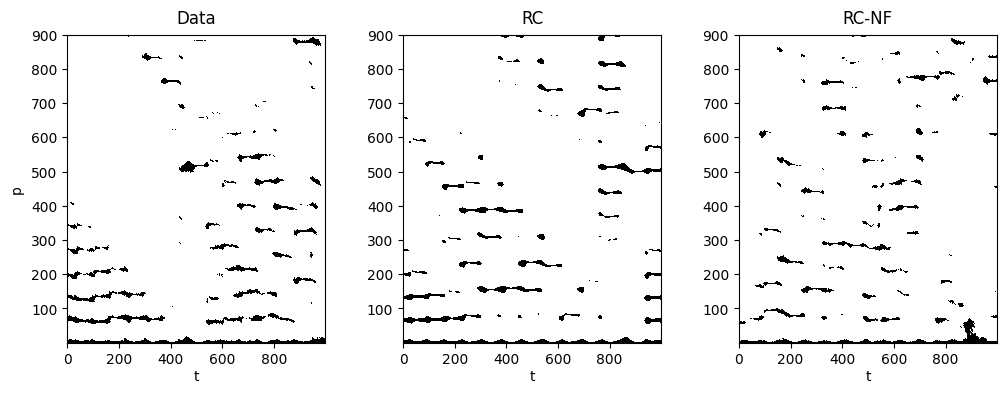

In [110]:
#close return maps
import matplotlib
# norm = matplotlib.colors.Normalize(vmin = np.min((trajectory_close_return, y_pred_close_return, y_pred_error_nr_close_return)), 
#                                    vmax = np.max((trajectory_close_return, y_pred_close_return, y_pred_error_nr_close_return)))
X_axis, Y_axis = np.meshgrid(i,  p)
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(wspace=0.3) 
ax1 = fig.add_subplot(131)    
ax1.pcolormesh(X_axis, Y_axis, trajectory_close_return[:,0*len(i):1*len(i)], cmap=plt.cm.binary) 
ax1.set_xlabel('t',labelpad=2)
ax1.set_ylabel('p',labelpad=5)
ax1.set_title('Data', pad=8)
ax2 = fig.add_subplot(132)    
ax2.pcolormesh(X_axis, Y_axis, y_pred_close_return[:,0*len(i):1*len(i)], cmap=plt.cm.binary) 
ax2.set_xlabel('t',labelpad=2)
ax2.set_title('RC', pad=8)
# ax2.set_ylabel('p')
ax3 = fig.add_subplot(133)    
ax3.pcolormesh(X_axis, Y_axis, y_pred_error_nr_close_return[:,0*len(i):1*len(i)], cmap=plt.cm.binary) 
ax3.set_xlabel('t',labelpad=2)
ax3.set_title('RC-NF', pad=8)
# ax3.set_ylabel('p')
# fig.subplots_adjust(right=0.9)
# position = fig.add_axes([0.92, 0.12,0.015,0.7])
# fig.colorbar(im3, cax = position)
# ax.set_zlabel('PDF', rotation =270, labelpad=-2.)
# fig.savefig('./image/lorenz/closereturn.jpg', dpi=500,format='jpg')

Text(0.5, 0, '$Z$')

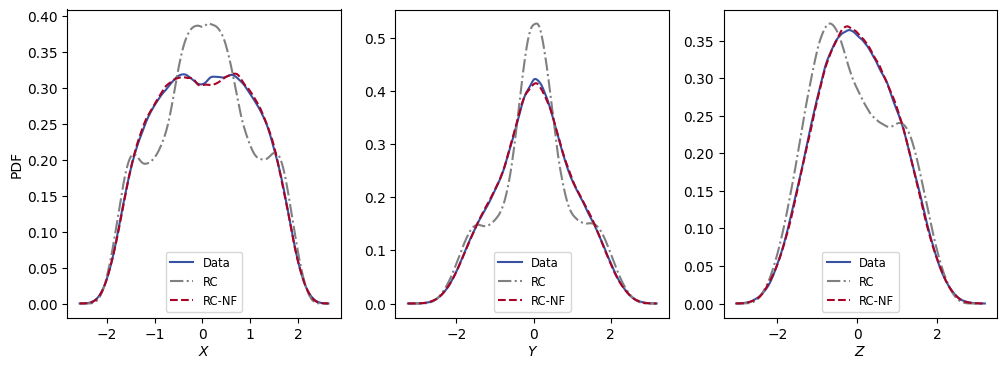

In [80]:
##pdf  of x, y, z on test dataset

fig,ax=plt.subplots(1,  inSize, figsize=(12, 4))
fig.subplots_adjust(wspace=0.2) 
for j in range(inSize):
    y_t = trajectory_all[j::inSize, trainLen + errorLen + 1: trainLen + errorLen + 1 + minLen].reshape(-1,)
    y_p = y_pred[j::inSize, :minLen].reshape(-1,)
    y_nr_p = y_pred_error_nr[j::inSize, :minLen].reshape(-1,)
    kde_t = sp.stats.gaussian_kde(y_t)
    kde_p = sp.stats.gaussian_kde(y_p)
    kde_nr_p = sp.stats.gaussian_kde(y_nr_p)
    
    x_axis = np.linspace(np.min((y_t,y_p,y_nr_p)), np.max((y_t,y_p,y_nr_p)), 200)
    ax[j].plot(x_axis, kde_t(x_axis), label="Data", color = '#3951A2',linestyle = '-')
    ax[j].plot(x_axis, kde_p(x_axis), label="RC", color = 'gray', linestyle = '-.')
    ax[j].plot(x_axis, kde_nr_p(x_axis), label="RC-NF", color = '#A80326',linestyle = '--')
    ax[j].legend(fontsize = 'small', loc = 'lower center')
#     ax[j].set_title('t = {}'.format((calculate_time_nr[i]+trainLen+errorLen)*dt))
        
ax[0].set_ylabel('PDF',labelpad=2)
# ax[1].set_ylabel('PDF $p(Y)$',labelpad=-1.2)
# ax[2].set_ylabel('PDF $p(Z)$',labelpad=-1.2)
ax[0].set_xlabel('$X$', labelpad=2)
ax[1].set_xlabel('$Y$', labelpad=2)
ax[2].set_xlabel('$Z$', labelpad=2)
   

# fig.text(0.5, 0.02, '$X_t$s\' position', va='center', ha='center', fontsize='large')
# fig.savefig('./image/lorenz/xyzpdf.jpg',dpi=500,format='jpg')

**criterion: maximum lypapunov exponent**

In [81]:
#maximum luapunov exponent
from nolitsa import lyapunov
meanperiod = 30
maxt = 150
t_ly = np.arange(maxt) *dt

true_d = np.zeros((trajectory_N, maxt))
y_pred_d = np.zeros((trajectory_N, maxt))
y_pred_nr_d = np.zeros((trajectory_N, maxt))


for i in range(trajectory_N):
    true_d[i] = lyapunov.mle(trajectory_all[i*inSize:(i+1)*inSize, trainLen+errorLen+1:trainLen+errorLen+1+minLen].T, maxt=maxt, window=meanperiod)

    y_pred_d[i] =  lyapunov.mle(y_pred[i*inSize:(i+1)*inSize,:minLen].T, maxt=maxt, window=meanperiod)

    y_pred_nr_d[i] = lyapunov.mle(y_pred_error_nr[i*inSize:(i+1)*inSize,:minLen].T, maxt=maxt, window=meanperiod)

    
    
    

In [82]:
true_coefs = []
y_pred_coefs = []
y_pred_nr_coefs = []
for i in range(trajectory_N):
    true_coefs.append(np.polyfit(t_ly[:70], true_d[i][:70], 1))
    y_pred_coefs.append(np.polyfit(t_ly[:70], y_pred_d[i][:70], 1))
    y_pred_nr_coefs.append(np.polyfit(t_ly[:70], y_pred_nr_d[i][:70], 1))

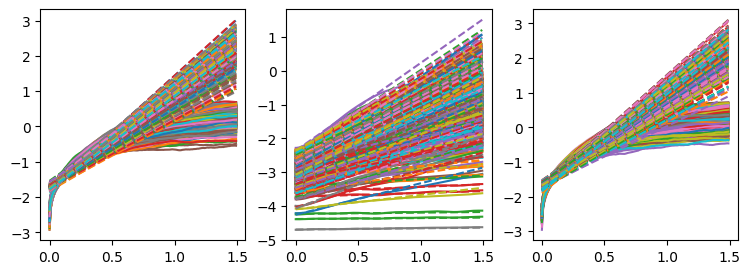

In [83]:
fig,ax=plt.subplots(1,  inSize, figsize=(9, 3))
ax[0].plot(t_ly.repeat(trajectory_N).reshape(trajectory_N,-1,order='F').T,  true_d.T)
for i in range(trajectory_N):
    ax[0].plot(t_ly, true_coefs[i][1] +true_coefs[i][0]* t_ly, '--')
    
ax[1].plot(t_ly.repeat(trajectory_N).reshape(trajectory_N,-1,order='F').T,  y_pred_d.T)
for i in range(trajectory_N):
    ax[1].plot(t_ly, y_pred_coefs[i][1] +y_pred_coefs[i][0]* t_ly, '--')
    
ax[2].plot(t_ly.repeat(trajectory_N).reshape(trajectory_N,-1,order='F').T,  y_pred_nr_d.T)
for i in range(trajectory_N):
    ax[2].plot(t_ly, y_pred_nr_coefs[i][1] +y_pred_nr_coefs[i][0]* t_ly, '--')

Text(0.5, 0, 'Maximum Lyapunov exponent')

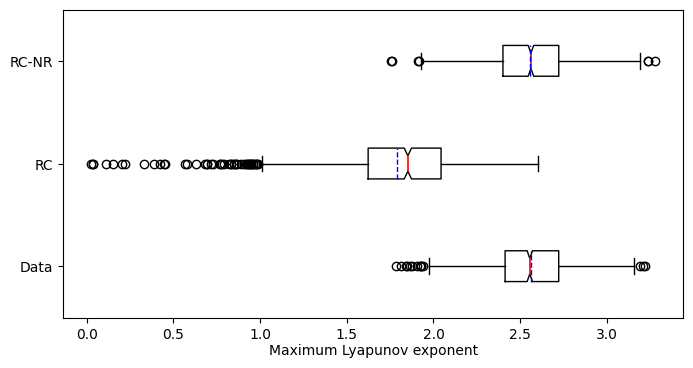

In [84]:
coefs00 = [true_coefs[i][0] for i in range(trajectory_N)]
coefs10 = [y_pred_coefs[i][0] for i in range(trajectory_N)]
coefs20 = [y_pred_nr_coefs[i][0] for i in range(trajectory_N)]
plt.figure(figsize=(8,4))
plt.boxplot([coefs00, coefs10, coefs20], vert=False, notch=True, labels=['Data', 'RC', 'RC-NR'],
           showmeans=True, meanline=True, meanprops=dict(color='b', linestyle= '--'),
           medianprops=dict(color='r', linewidth=1.2))
plt.xlabel('Maximum Lyapunov exponent',labelpad=2)
# plt.savefig('./image/lorenz/lyapunov.jpg',dpi=500, format='jpg')

In [85]:
print('data maximum lyapunov (mean):', np.mean(coefs00),
     'data maximum lyapunov (median):', np.median(coefs00),'\n'
     'rc prediction maximum lyapunov (mean):', np.mean(coefs10),
     'rc prediction maximum lyapunov (median):', np.median(coefs10),'\n'
     'rc-nr prediction maximum lyapunov (mean):', np.mean(coefs20),
     'rc-nr prediction maximum lyapunov (median):', np.median(coefs20))

data maximum lyapunov (mean): 2.5609133794741137 data maximum lyapunov (median): 2.5556947855800916 
rc prediction maximum lyapunov (mean): 1.7881249065206637 rc prediction maximum lyapunov (median): 1.8524861534132513 
rc-nr prediction maximum lyapunov (mean): 2.5592180937033806 rc-nr prediction maximum lyapunov (median): 2.5622467014747796


**generate a long trajectory**

In [89]:
#acf for an orbit

orbit_N = 1#number of trajectories

delta_t = 0.00001
scale = 1000
dt= delta_t*scale #0.01

y0 = np.array([0.,1.,0.])

sigma = 10.
rho = 28.
beta = 8/3

t2 = np.arange(0, 10000., delta_t)
tt = t2[::scale]

orbit_al = np.zeros((orbit_N*inSize, len(tt)))

def f(x, t):
    dx = sigma*(x[1]-x[0])
    dy = x[0]*(rho-x[2])-x[1]
    dz = x[0]*x[1]-beta*x[2]
    return np.array([dx,dy,dz])

def g(x, t):
    return np.array([[3.,0.,0.]
                    ,[0.,3.,0.]
                    ,[0.,0.,3.]])

###The first run requires that the trajectory data be generated and saved

# for i in range(orbit_N):
#     result = sdeint.itoEuler(f, g, y0, t2, generator = np.random.default_rng(i+10000)) 
#     orbit_al[i*inSize:(i+1)*inSize] = result.T[:,::scale]
# plt.plot(tt, orbit_al.T[:,:]) 



In [90]:
# #trajectory mean and variance at each axis
# mean_std_orbit = np.zeros((inSize,2)) #xmean,xstd,ymean,ystd,zmean,zstd
# for i in range(0,inSize):
#     mean_std_orbit[i,0] = np.mean(orbit_al[i::3,:])
#     mean_std_orbit[i,1] = np.std(orbit_al[i::3,:])
# mean_std_orbit_all = np.tile(mean_std_orbit,(orbit_N,1))
# orbit_all = (orbit_al - mean_std_orbit_all[:,0].reshape(-1,1))/mean_std_orbit_all[:,1].reshape(-1,1)

In [91]:
# np.save('./data/lorenzonetrack.npy', orbit_all)
orbit_all = np.load('./data/lorenzonetrack.npy')

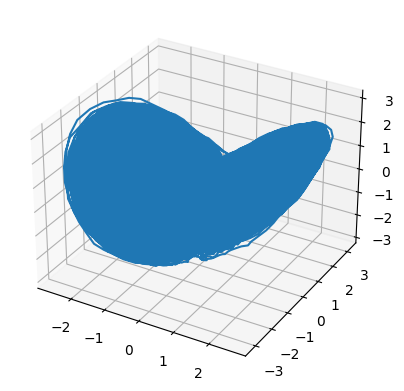

In [92]:
fig  =plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(orbit_all[0], orbit_all[1], orbit_all[2])

In [93]:
torch.manual_seed(11) #8,11
initLen = 500

x_ = torch.Tensor(error_train_nr_flatten)
error_data__ = model_nr.sample((len(tt)-initLen)).data.numpy()
error_data_ = error_data__ * torch.std(x_,axis=1).numpy() + torch.mean(x_, axis=1).numpy()
error_data = error_data_.T

orbit_init = orbit_all[:,:initLen]


yyy = universality(ESN_par, orbit_init, Win, W, Wout, error_data)

yy = universality(ESN_par, orbit_init, Win, W, Wout, error_data*0)


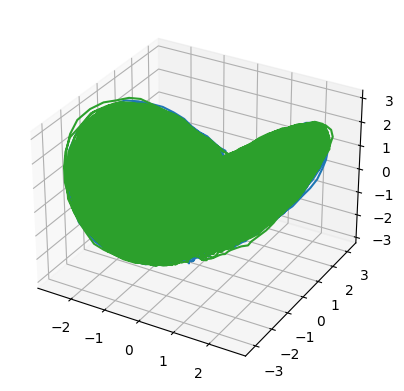

In [94]:
fig  =plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(yyy[0], yyy[1], yyy[2])
ax.plot(yy[0], yy[1], yy[2])
ax.plot(orbit_all[0], orbit_all[1], orbit_all[2])

In [95]:
#ccf
from statsmodels.tsa.stattools import ccf
ccf_data_o = [] 
ccf_rc_o = [] 
ccf_nr_o = [] 

x_ax,y_ax = np.meshgrid(np.arange(inSize),np.arange(inSize))
x_ax = x_ax.flatten() #array([0, 1, 2, 0, 1, 2, 0, 1, 2])
y_ax = y_ax.flatten() #array([0, 0, 0, 1, 1, 1, 2, 2, 2])

for k in range(inSize * inSize):
    ccf_n = np.zeros((orbit_N, len(tt)-initLen))
    for n in range(orbit_N):
        ccf_n[n] = ccf(orbit_all[y_ax[k]+n*inSize, initLen:], 
                      orbit_all[x_ax[k]+n*inSize, initLen:])
    ccf_data_o.append(ccf_n)

for k in range(inSize * inSize):
    ccf_n = np.zeros((orbit_N, len(tt)-initLen))
    for n in range(orbit_N):
        ccf_n[n] = ccf(yy[y_ax[k]+n*inSize, :], yy[x_ax[k]+n*inSize,:])
    ccf_rc_o.append(ccf_n)

for k in range(inSize * inSize):
    ccf_n = np.zeros((orbit_N, len(tt)-initLen))
    for n in range(orbit_N):
        ccf_n[n] = ccf(yyy[y_ax[k]+n*inSize,:], yyy[x_ax[k]+n*inSize,:])
    ccf_nr_o.append(ccf_n)



Text(0.5, 0, '$Z$')

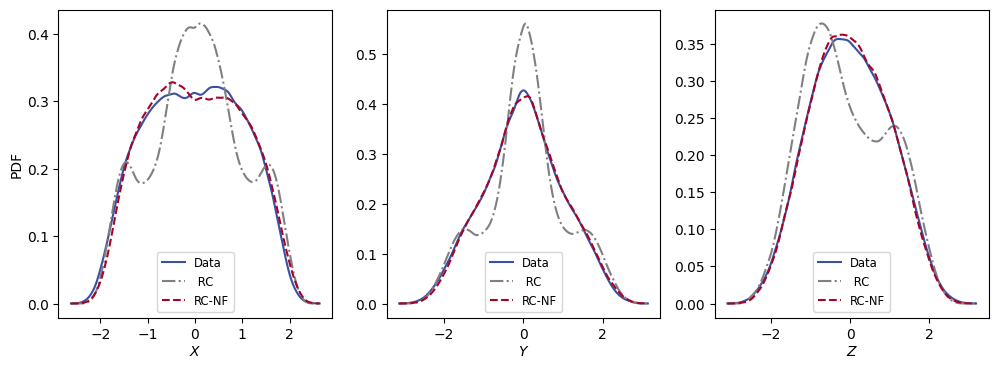

In [96]:
##pdf  of x, y, z

fig,ax=plt.subplots(1,  inSize, figsize=(12, 4))
fig.subplots_adjust(wspace=0.2) 
for j in range(inSize):
    y_t = orbit_all[j::inSize, initLen:].reshape(-1,)
    y_p = yy[j::inSize, :].reshape(-1,)
    y_nr_p = yyy[j::inSize, :].reshape(-1,)
    kde_t = sp.stats.gaussian_kde(y_t)
    kde_p = sp.stats.gaussian_kde(y_p)
    kde_nr_p = sp.stats.gaussian_kde(y_nr_p)
    
    x_axis = np.linspace(np.min((y_t,y_p,y_nr_p)), np.max((y_t,y_p,y_nr_p)), 200)
    ax[j].plot(x_axis, kde_t(x_axis), label="Data", color = '#3951A2',linestyle = '-')
    ax[j].plot(x_axis, kde_p(x_axis), label=" RC", color = 'gray', linestyle = '-.')
    ax[j].plot(x_axis, kde_nr_p(x_axis), label="RC-NF", color = '#A80326',linestyle = '--')
    ax[j].legend(fontsize = 'small', loc = 'lower center')
#     ax[j].set_title('t = {}'.format((calculate_time_nr[i]+trainLen+errorLen)*dt))
        
ax[0].set_ylabel('PDF',labelpad=2)
# ax[1].set_ylabel('PDF $p(Y)$',labelpad=0)
# ax[2].set_ylabel('PDF $p(Z)$',labelpad=0)
ax[0].set_xlabel('$X$', labelpad=2)
ax[1].set_xlabel('$Y$', labelpad=2)
ax[2].set_xlabel('$Z$', labelpad=2)
   

# fig.text(0.5, 0.02, '$X_t$s\' position', va='center', ha='center', fontsize='large')
# fig.savefig('./image/lorenz/xyzpdfonetrack.jpg',dpi=500,format='jpg')

**criterion: autocorrelation and cross-correlation**

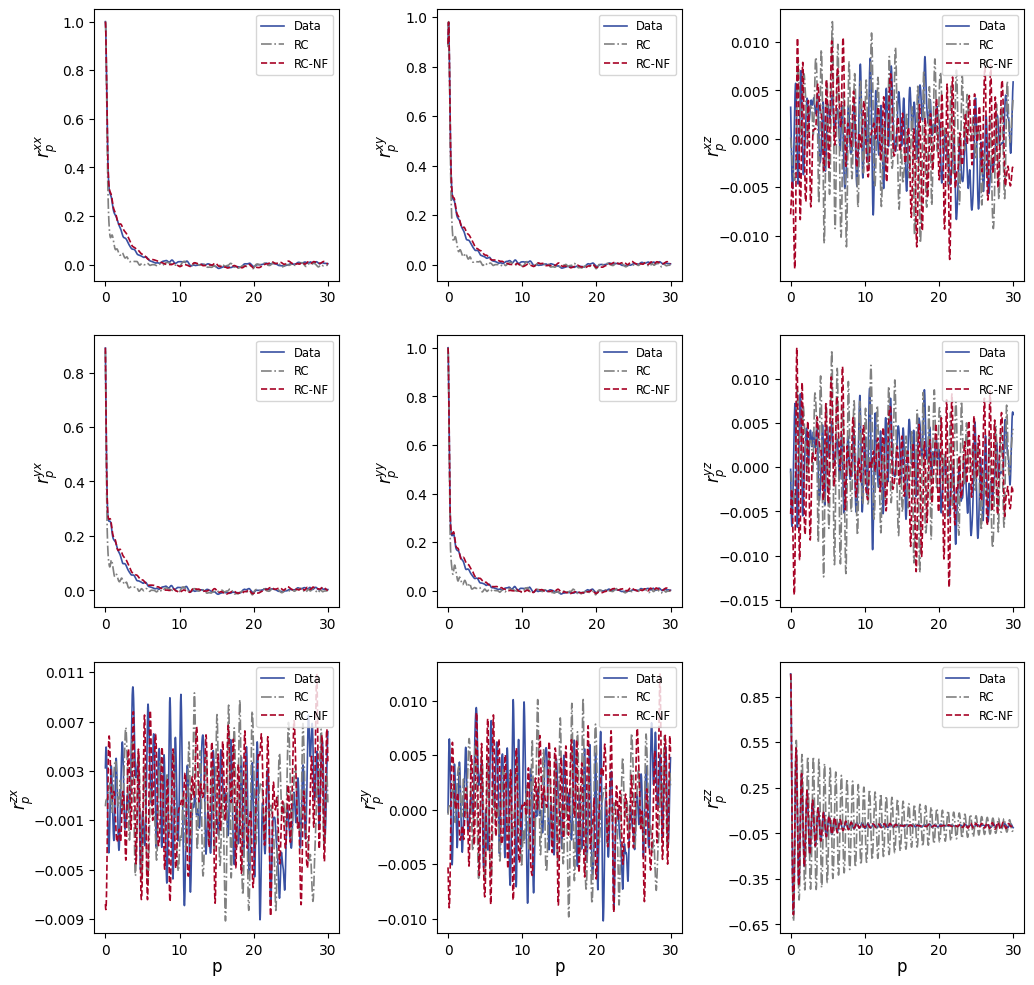

In [144]:

fig,ax=plt.subplots(inSize, inSize, figsize=(12, 12))
fig.subplots_adjust(wspace=0.4, hspace=0.2)
trunction = 3000

for k in range(inSize*inSize):
    ax[y_ax[k]][x_ax[k]].plot((np.arange(len(ccf_data_o[k].reshape(-1,)[:trunction]))*dt), ccf_data_o[k].reshape(-1,)[:trunction],label="Data",color = '#3951A2',linewidth=1.2)
#     ax[y_ax[k]][x_ax[k]].fill_between((np.arange(minLen)*dt)[:trunction], np.percentile(ccf_data[k][:, :trunction], 2.5, axis = 0), np.percentile(ccf_data[k][:, :trunction], 97.5, axis = 0), alpha = 0.15, color = '#3951A2', label='95% Confidence (Data)')
    ax[y_ax[k]][x_ax[k]].plot((np.arange(len(ccf_rc_o[k].reshape(-1,)[:trunction]))*dt), ccf_rc_o[k].reshape(-1,)[:trunction], label="RC", color = 'gray', linestyle = '-.',linewidth=1.2)
#     ax[y_ax[k]][x_ax[k]].fill_between((np.arange(minLen)*dt)[:trunction], np.percentile(ccf_rc[k][:, :trunction], 2.5, axis = 0), np.percentile(ccf_rc[k][:, :trunction], 97.5, axis = 0), alpha = 0.15,color = 'gray', label='95% Confidence (RC)')
    ax[y_ax[k]][x_ax[k]].plot((np.arange(len(ccf_nr_o[k].reshape(-1,)[:trunction]))*dt), ccf_nr_o[k].reshape(-1,)[:trunction], label="RC-NF", color = '#A80326',linestyle = '--',linewidth=1.2)
#     ax[y_ax[k]][x_ax[k]].fill_between((np.arange(minLen)*dt)[:trunction], np.percentile(ccf_nr[k][:, :trunction], 2.5, axis = 0), np.percentile(ccf_nr[k][:, :trunction], 97.5, axis = 0), alpha = 0.15, color = '#DA382A', label='95% Confidence (RC-NF)')  
    ax[y_ax[k]][x_ax[k]].legend(fontsize ='small')
#     ax[y_ax[k]][x_ax[k]].set_xlabel('p',labelpad=0)

ax[0][0].set_ylabel('$r^{xx}_p$', labelpad=2, fontsize=12)
ax[0][1].set_ylabel('$r^{xy}_p$', labelpad=2, fontsize=12) 
ax[0][2].set_ylabel('$r^{xz}_p$', labelpad=-8, fontsize=12) 
ax[1][0].set_ylabel('$r^{yx}_p$', labelpad=2, fontsize=12) 
ax[1][1].set_ylabel('$r^{yy}_p$', labelpad=2, fontsize=12) 
ax[1][2].set_ylabel('$r^{yz}_p$', labelpad=-8, fontsize=12) 
ax[2][0].set_ylabel('$r^{zx}_p$', labelpad=-2, fontsize=12) 
ax[2][0].set_yticks(np.arange(-0.009, 0.013,0.004)) 
ax[2][1].set_ylabel('$r^{zy}_p$', labelpad=-8, fontsize=12) 
ax[2][2].set_ylabel('$r^{zz}_p$', labelpad=-2, fontsize=12) 
ax[2][2].set_yticks(np.arange(-0.65, 1.1,0.3))
ax[2][0].set_xlabel('p',labelpad=0, fontsize=12)
ax[2][1].set_xlabel('p',labelpad=0, fontsize=12)
ax[2][2].set_xlabel('p',labelpad=0, fontsize=12)
# fig.savefig('./image/lorenz/ccf.jpg', dpi =500, format = 'jpg')